In [1]:
import astropy
import numpy as np
import glob
from glob import glob
from astropy.io import fits
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
m_selection = np.array([[9, 9.5], 
                       [9.5, 10.0],
                       [10.0, 10.5],
                       [10.5, 11.0]])

z_selection = np.array([[0.7, 2.0]])
z_selection = np.array([[0.7, 1.3],[1.3, 2.0]])

sn = 1.
new_cat_dir = '/Users/rsimons/Desktop/clear/Catalogs'

## strong-line calibration from Bian+ 18

In [3]:
def OH_mc(O3, O2, eO3, eO2):
    if O3 < 0: return nan, nan
    if O2 < 0: return nan, nan

    O3_arr = np.random.normal(O3, eO3, 10000)
    O2_arr = np.random.normal(O2, eO2, 10000)
    OH_z_arr = 8.54 - 0.59 * O3_arr/O2_arr
    e_an = 0.59*((O3/O2) * sqrt((eO3/O3)**2. + (eO2/O2)**2.))
    #print ('%.2f  %.2f  %.2f  %.2f   %.2f  %.2f' %(np.mean(OH_z_arr), np.std(OH_z_arr), O3, O2, eO3, eO2))
    
    return np.mean(OH_z_arr), e_an#np.std(OH_z_arr)


def OH(O3, O2, eO3, eO2):   
    OH = 8.54 - 0.59 * log10(O3/O2)
    e_an = 0.59*((O3/O2) * sqrt((eO3/O3)**2. + (eO2/O2)**2.))
    
    return OH, e_an



## Collect and concatenate v2.0 catalogs

In [19]:
cat_dir = '/Users/rsimons/Dropbox/grizli_v2.0_cats'
cat_dir = '/Users/rsimons/Desktop/clear/Catalogs/grizli_v2.1_cats'

cat_fls = glob(cat_dir + '/*grizli.fits')
fast_gds = fits.open('/Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout.FITS')
fast_gdn = fits.open('/Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout.FITS')

galfit_gds = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/allfields/goodss/goodss_3dhst.v4.1_f160w.galfit')
galfit_gdn = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/allfields/goodsn/goodsn_3dhst.v4.1_f160w.galfit')

cat_tables = []
for cc, cat_fl in enumerate(cat_fls):
    field = cat_fl.split('/')[-1].split('_')[0]
    cat = fits.open(cat_fl)
    col1= fits.Column(name='field', format='10A', array=array([field for i in arange(len(cat[1].data))]))
    x =0
    y = 0
    lmass, lsfr, av, metal, lage, re, n, q, pa = [], [], [], [], [], [], [], [], []
    for i in arange(len(cat[1].data)):
        if field.startswith('GN'): 
            fast_cat = fast_gdn[1]
            galf_cat = galfit_gdn
        if field.startswith('GS'): 
            fast_cat = fast_gds[1]
            galf_cat = galfit_gds
        
        galf_match = where(galf_cat[:,0] == cat[1].data['ID'][i])
        fast_match = where(fast_cat.data['ID'] == cat[1].data['ID'][i])[0][0]

        re.append(galf_cat[galf_match, 6])
        n.append(galf_cat[galf_match, 8])
        q.append(galf_cat[galf_match, 10])
        pa.append(galf_cat[galf_match, 12])
        
        lmass.append(fast_cat.data['lmass'][fast_match])            
        lsfr.append(fast_cat.data['lsfr'][fast_match])            
        av.append(fast_cat.data['av'][fast_match])            
        metal.append(fast_cat.data['metal'][fast_match])            
        lage.append(fast_cat.data['lage'][fast_match])    
        
    lmass = array(lmass)
    lsfr  = array(lsfr )
    av    = array(av   )
    metal = array(metal)
    lage  = array(lage )
    re  = array(re )
    n   = array(n )
    q   = array(q )
    pa  = array(pa )
        
        
    col2  = fits.Column(name='lmass', format='D', array=lmass)
    col3  = fits.Column(name='lsfr',  format='D', array=lsfr)
    col4  = fits.Column(name='av',    format='D', array=av)
    col5  = fits.Column(name='metal', format='D', array=metal)
    col6  = fits.Column(name='lage',  format='D', array=lage)    
    col7  = fits.Column(name='re',    format='D', array=re)
    col8  = fits.Column(name='n',     format='D', array=n)
    col9  = fits.Column(name='q',     format='D', array=q)
    col10 = fits.Column(name='pa',    format='D', array=pa)    
    
    new_cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10])
    hdu = fits.BinTableHDU.from_columns(new_cols + cat[1].columns)    
    cat_tables.append(hdu)
    
    
cat_tables = array(cat_tables)



## Select sample

In [20]:
for zz, z_bin in enumerate(z_selection):
    print ('%.1f < z < %.1f'%(z_bin[0], z_bin[1]))
    for mm, m_bin in enumerate(m_selection):
        print ('\t%.1f < z < %.1f'%(m_bin[0], m_bin[1]))
        ha_num, o3_num, o32_num, o2_num, hb_num = 0, 0, 0, 0, 0
        ha_cts = []
        hb_cts = []
        o2_cts = []
        o3_cts = []
        o32_cts = []
        
        for cc, cat_table in enumerate(cat_tables):
            
            o2_gd = where((cat_table.data['lmass'] > m_bin[0]) &
                         (cat_table.data['lmass'] < m_bin[1]) & 
                         (cat_table.data['z_50']  > z_bin[0]) & 
                         (cat_table.data['z_50']  < z_bin[1]) &
                         (cat_table.data['OII_FLUX']/cat_table.data['OII_FLUX_ERR']  > sn)) [0]
            
            o3_gd = where((cat_table.data['lmass'] > m_bin[0]) &
                         (cat_table.data['lmass'] < m_bin[1]) & 
                         (cat_table.data['z_50']  > z_bin[0]) & 
                         (cat_table.data['z_50']  < z_bin[1]) &
                         (cat_table.data['OIII_FLUX']/cat_table.data['OIII_FLUX_ERR']  > sn)) [0]
            
            ha_gd = where((cat_table.data['lmass'] > m_bin[0]) &
                         (cat_table.data['lmass'] < m_bin[1]) & 
                         (cat_table.data['z_50']  > z_bin[0]) & 
                         (cat_table.data['z_50']  < z_bin[1]) &
                         (cat_table.data['Ha_FLUX']/cat_table.data['Ha_FLUX_ERR']  > sn)) [0]

            hb_gd = where((cat_table.data['lmass'] > m_bin[0]) &
                         (cat_table.data['lmass'] < m_bin[1]) & 
                         (cat_table.data['z_50']  > z_bin[0]) & 
                         (cat_table.data['z_50']  < z_bin[1]) &
                         (cat_table.data['Hb_FLUX']/cat_table.data['Hb_FLUX_ERR']  > sn)) [0]

            o32_gd = where((cat_table.data['lmass'] > m_bin[0]) &
                           (cat_table.data['lmass'] < m_bin[1]) & 
                           (cat_table.data['z_50']  > z_bin[0]) & 
                           (cat_table.data['z_50']  < z_bin[1]) &
                           (cat_table.data['OII_FLUX']/cat_table.data['OII_FLUX_ERR']  > sn) &
                           (cat_table.data['OIII_FLUX']/cat_table.data['OIII_FLUX_ERR']  > sn)) [0]

            
            
            
            for i in arange(len(ha_gd)):
                ha_cts.append([cat_table.data['field'][ha_gd[i]], cat_table.data['ID'][ha_gd[i]], cat_table.data['z_50'][ha_gd[i]], cat_table.data['lmass'][ha_gd[i]], cat_table.data['Ha_FLUX'][ha_gd[i]], cat_table.data['Ha_FLUX_ERR'][ha_gd[i]], cat_table.data['re'][ha_gd[i]],  cat_table.data['pa'][ha_gd[i]],  cat_table.data['q'][ha_gd[i]]])
            for i in arange(len(hb_gd)):
                hb_cts.append([cat_table.data['field'][hb_gd[i]], cat_table.data['ID'][hb_gd[i]], cat_table.data['z_50'][hb_gd[i]], cat_table.data['lmass'][hb_gd[i]], cat_table.data['Hb_FLUX'][hb_gd[i]], cat_table.data['Hb_FLUX_ERR'][hb_gd[i]], cat_table.data['re'][hb_gd[i]],  cat_table.data['pa'][hb_gd[i]],  cat_table.data['q'][hb_gd[i]]])
            for i in arange(len(o2_gd)):
                o2_cts.append([cat_table.data['field'][o2_gd[i]], cat_table.data['ID'][o2_gd[i]], cat_table.data['z_50'][o2_gd[i]], cat_table.data['lmass'][o2_gd[i]], cat_table.data['OII_FLUX'][o2_gd[i]], cat_table.data['OII_FLUX_ERR'][o2_gd[i]], cat_table.data['re'][o2_gd[i]],  cat_table.data['pa'][o2_gd[i]],  cat_table.data['q'][o2_gd[i]]])
            for i in arange(len(o3_gd)):
                o3_cts.append((cat_table.data['field'][o3_gd[i]], cat_table.data['ID'][o3_gd[i]], cat_table.data['z_50'][o3_gd[i]], cat_table.data['lmass'][o3_gd[i]], cat_table.data['OIII_FLUX'][o3_gd[i]], cat_table.data['OIII_FLUX_ERR'][o3_gd[i]], cat_table.data['re'][o3_gd[i]],  cat_table.data['pa'][o3_gd[i]],  cat_table.data['q'][o3_gd[i]]))
            for i in arange(len(o32_gd)):
                o32_cts.append((cat_table.data['field'][o32_gd[i]], cat_table.data['ID'][o32_gd[i]], cat_table.data['z_50'][o32_gd[i]], cat_table.data['lmass'][o32_gd[i]], cat_table.data['OIII_FLUX'][o32_gd[i]], cat_table.data['OIII_FLUX_ERR'][o32_gd[i]], cat_table.data['re'][o32_gd[i]],  cat_table.data['pa'][o32_gd[i]],  cat_table.data['q'][o32_gd[i]]))

                
                
            ha_num+=len(ha_gd)
            hb_num+=len(hb_gd)
            o2_num+=len(o2_gd)
            o3_num+=len(o3_gd)    
            o32_num+=len(o32_gd)    
        print ('\t\t N(Ha) = %i'%ha_num)
        print ('\t\t N(Hb) = %i'%hb_num)
        print ('\t\t N(O2) = %i'%o2_num)
        print ('\t\t N(O3) = %i'%o3_num)
        print ('\t\t N(O32) = %i'%o32_num)

        ha_cts = array(ha_cts)
        hb_cts = array(hb_cts)
        o2_cts = array(o2_cts)
        o3_cts = array(o3_cts)     
        o32_cts = array(o32_cts)     

            
        np.save(new_cat_dir + '/ha_%.1f_%.1f_%.1f_%.1f.npy'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), ha_cts)
        np.save(new_cat_dir + '/hb_%.1f_%.1f_%.1f_%.1f.npy'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), hb_cts)
        np.save(new_cat_dir + '/o2_%.1f_%.1f_%.1f_%.1f.npy'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), o2_cts)
        np.save(new_cat_dir + '/o3_%.1f_%.1f_%.1f_%.1f.npy'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), o3_cts)
        np.save(new_cat_dir + '/o32_%.1f_%.1f_%.1f_%.1f.npy'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), o32_cts)
        
                
        
        

0.7 < z < 2.0
	9.0 < z < 9.5


/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invali

		 N(Ha) = 203
		 N(Hb) = 133
		 N(O2) = 120
		 N(O3) = 219
		 N(O32) = 98
	9.5 < z < 10.0
		 N(Ha) = 122
		 N(Hb) = 81
		 N(O2) = 83
		 N(O3) = 124
		 N(O32) = 56
	10.0 < z < 10.5
		 N(Ha) = 92
		 N(Hb) = 60
		 N(O2) = 51
		 N(O3) = 82
		 N(O32) = 31
	10.5 < z < 11.0
		 N(Ha) = 52
		 N(Hb) = 28
		 N(O2) = 29
		 N(O3) = 36
		 N(O32) = 12


In [21]:
lines = ['ha', 'hb', 'o2', 'o3', 'o32']
lines_f = ['Ha', 'Hb', 'OII', 'OIII', 'O32']



for zz, z_bin in enumerate(z_selection):
    print ('%.1f < z < %.1f'%(z_bin[0], z_bin[1]))    
    for mm, m_bin in enumerate(m_selection):
        print ('\t%.1f < z < %.1f'%(m_bin[0], m_bin[1]))            
        for ll, line in enumerate(lines):
            print ('\t' + line)
            cts = np.load(new_cat_dir + '/%s_%.1f_%.1f_%.1f_%.1f.npy'%(line, z_bin[0], z_bin[1], m_bin[0], m_bin[1]))
            if line == 'o32': ct_data = zeros((len(cts), 80, 80, 4)) * nan
            else:             ct_data = zeros((len(cts), 80, 80, 2)) * nan

            for o, obj in enumerate(cts):
                fld, did = obj[0], obj[1]
                #fl = glob('/Volumes/gdrive/clear/grizli_extractions/%s/*/Prep/%s_%s.full.fits'%(fld, fld, did))
                fl = glob('/Users/rsimons/Dropbox/rcs_clear/grizli_v2.1/all_full/%s_%s.full.fits'%(fld, did))
                if len(fl) > 0:
                    fl = fl[0]
                    data = fits.open(fl)
                    if line == 'o32':
                        ct_data[o,:,:,0] = data['LINE', 'OII'].data
                        ct_data[o,:,:,1] = 1./sqrt(data['LINEWHT', 'OII'].data)
                        ct_data[o,:,:,2] = data['LINE', 'OIII'].data
                        ct_data[o,:,:,3] = 1./sqrt(data['LINEWHT', 'OIII'].data)

                    else:
                        ct_data[o,:,:,0] = data['LINE', '%s'%lines_f[ll]].data
                        ct_data[o,:,:,1] = 1./sqrt(data['LINEWHT', '%s'%lines_f[ll]].data)            

                else:
                    print ('no files')
            fits.writeto(new_cat_dir + '/%s_%.1f_%.1f_%.1f_%.1f.fits'%
                         (line, z_bin[0], z_bin[1], m_bin[0], m_bin[1]), ct_data, overwrite = True)


0.7 < z < 2.0
	9.0 < z < 9.5
	ha


/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


no files
	hb
no files
	o2
	o3
no files
	o32


/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


	9.5 < z < 10.0
	ha
	hb
	o2
no files
	o3
	o32
	10.0 < z < 10.5
	ha
no files
	hb
	o2
	o3
	o32
	10.5 < z < 11.0
	ha
no files
	hb
no files
	o2
no files
	o3
no files
	o32


In [39]:
b = np.load(new_cat_dir + '/o32_0.7_2.0_10.5_11.0.npy')[()]

In [54]:
math.cos

<function math.cos>

## Stacked line profiles

0.7 < z < 2.0
	10.5 < z < 11.0


/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


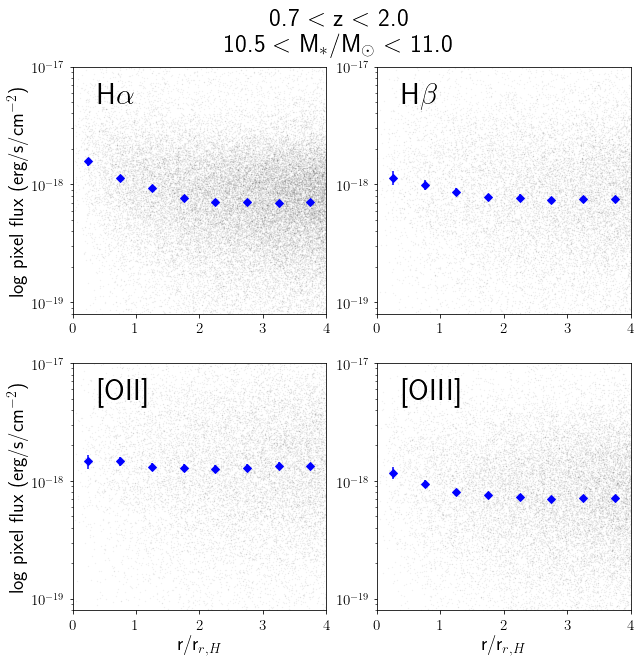

In [62]:
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 15


X,Y = np.meshgrid(np.arange(-40, 40, 1)*0.1, np.arange(-40, 40, 1)*0.1)



r = sqrt(X**2. + Y**2.)
r+= np.random.normal(0, 0.1, shape(r))

lines = array(['ha', 'hb', 'o2', 'o3'])
line_str = array([r'H$\alpha$', r'H$\beta$', '[OII]', '[OIII]'])

bins_median = arange(0., 4.9, 0.5)

for zz, z_bin in enumerate(z_selection):
    print ('%.1f < z < %.1f'%(z_bin[0], z_bin[1]))    
    for mm, m_bin in enumerate(m_selection[3:4]):
        print ('\t%.1f < z < %.1f'%(m_bin[0], m_bin[1]))    
        fig, axes = plt.subplots(2,2, figsize = (10,10))
        for ll, line in enumerate(lines):
            ax = axes.ravel()[ll]
            data = fits.getdata(new_cat_dir + '/%s_%.1f_%.1f_%.1f_%.1f.fits'%(line, z_bin[0], z_bin[1], m_bin[0], m_bin[1]))
            cts = np.load(new_cat_dir + '/%s_%.1f_%.1f_%.1f_%.1f.npy'%(line, z_bin[0], z_bin[1], m_bin[0], m_bin[1]))
            rs = array([])
            fs = array([])
            for i in arange(len(data)):
                f  = data[i,:,:,0] * 1.e-17
                gd = where(f > 0.)
                ms = 0.5
                alp = 0.1
                if float(cts[i,6]) < 2.:
                    pa = float(cts[i, -2])
                    r_p = sqrt((X * math.cos(pa * pi/180.))**2. + (Y* math.cos(pa * pi/180.))**2.)
                    re = r/float(cts[i,6])
                    #re = r_p/float(cts[i,6])
                    ax.plot(re[gd].ravel(), f[gd].ravel(), 'k.', 
                            markersize = ms, alpha = alp)
                    rs = concatenate([rs, re[gd].ravel()])
                    fs = concatenate([fs, f[gd].ravel()])
        
            for rr, rfit in enumerate(bins_median[1:len(bins_median) - 1]):
                gi = where((rs > bins_median[rr]) & (rs < bins_median[rr+1]))[0]
                mid_x = mean([bins_median[rr], bins_median[rr+1]])
                st = std(log10(fs[gi]))
                st_u = 10**(log10(median(fs[gi])) + st) - median(fs[gi])
                st_l = median(fs[gi]) - 10**(log10(median(fs[gi])) + st)                
                ax.errorbar(mid_x, median(fs[gi]), yerr = array([(st_l/sqrt(len(gi)), st_u/sqrt(len(gi)))]), marker = 'D', color = 'blue')
                           
            ax.annotate(line_str[ll], (0.1, 0.85), xycoords = 'axes fraction', fontsize = 30)
            ax.set_xlim(0, 4.)
            ax.set_ylim(8.e-20, 1.e-17)
            if ll % 2 == 0: ax.set_ylabel('log pixel flux (erg/s/cm$^{-2}$)', fontsize = 20)
            ax.set_yscale('log')
            if ll > 1: ax.set_xlabel('r/r$_{r,H}$', fontsize = 20)
        axes[0,0].annotate('%.1f $<$ z $<$ %.1f\n%.1f $<$ M$_*$/M$_{\odot}$ $<$ %.1f'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), 
                           (1.05, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 25)
        fig.savefig('/Users/rsimons/Desktop/clear/figures/lp_%.1f_%.1f_%.1f_%.1f.png'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), dpi = 300.)


## [OIII]/[OII] ratio and O/H

0.7 < z < 2.0
	9.0 < z < 9.5


/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


	9.5 < z < 10.0
	10.0 < z < 10.5
	10.5 < z < 11.0


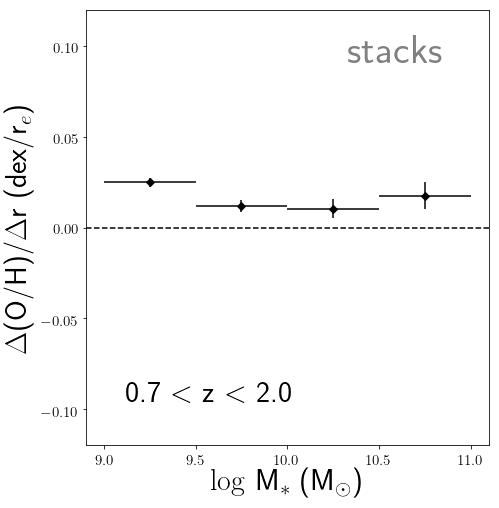

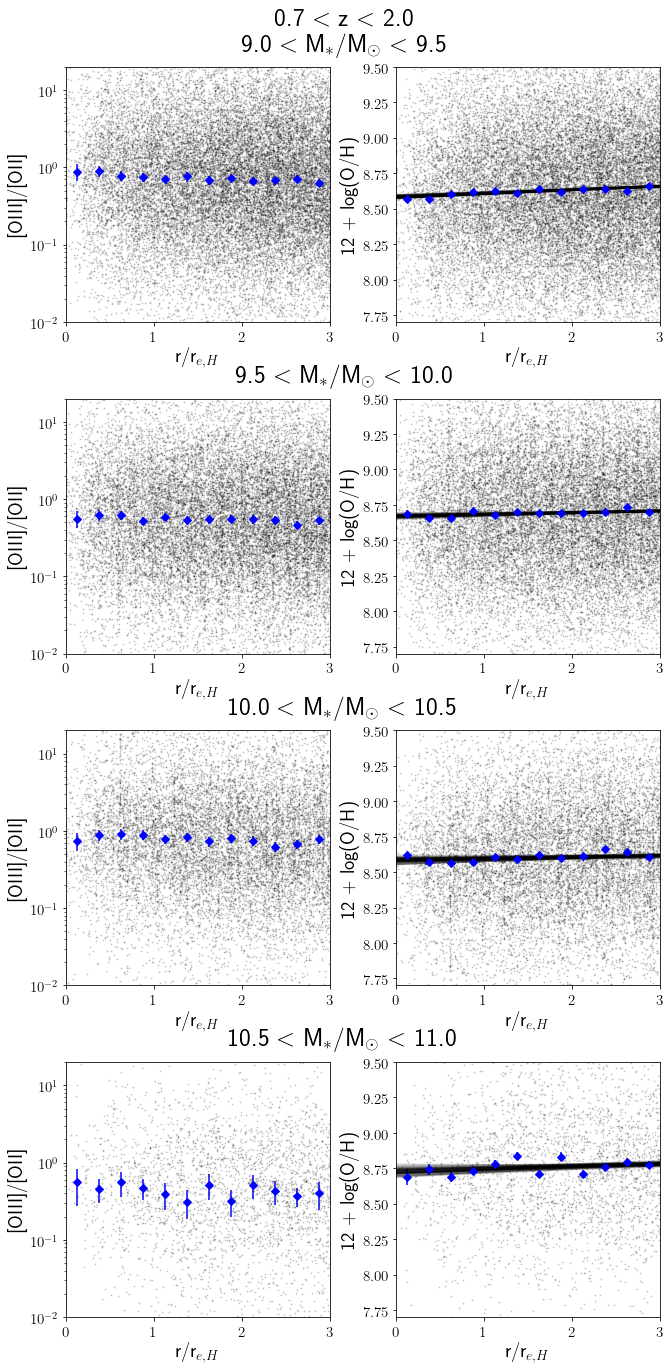

In [60]:
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15


X,Y = np.meshgrid(np.arange(-40, 40, 1)*0.1, np.arange(-40, 40, 1)*0.1)
r = sqrt(X**2. + Y**2.)
r+= np.random.normal(0, 0.1, shape(r))


lines = array(['o32'])
line_str = array(['[OIII]/[OII]'])



bins_median = arange(0., 5., 0.25)
np.random.seed(0)
fig2, axr = plt.subplots(1,1, figsize = (8,8))
clrs_z = ['darkblue', 'darkred', 'black']
clrs_z = ['black', 'darkred', 'black']

z_selection = np.array([[0.7, 1.3],[1.3, 2.0], [0.7, 2.0]])
z_selection = np.array([[0.7, 2.0]])

m_selection = np.array([[9, 9.5], 
                       [9.5, 10.0],
                       [10.0, 10.5],
                       [10.5, 11.0]])



for zz, z_bin in enumerate(z_selection):
    fig, axes = plt.subplots(len(m_selection),2, figsize = (10,23))
    print ('%.1f < z < %.1f'%(z_bin[0], z_bin[1]))    
    for mm, m_bin in enumerate(m_selection):
        print ('\t%.1f < z < %.1f'%(m_bin[0], m_bin[1]))    
        ax1 = axes[mm, 0]
        ax2 = axes[mm, 1]
        for ll, line in enumerate(lines):
            data = fits.getdata(new_cat_dir + '/%s_%.1f_%.1f_%.1f_%.1f.fits'%(line, z_bin[0], z_bin[1], m_bin[0], m_bin[1]))
            cts = np.load(new_cat_dir + '/%s_%.1f_%.1f_%.1f_%.1f.npy'%(line, z_bin[0], z_bin[1], m_bin[0], m_bin[1]))
            rs = array([])
            fs = array([])
            zs = array([])

            
            for i in arange(len(data)):
                O3 = data[i,:,:,2]
                O2 = data[i,:,:,0]
                eO3 = data[i,:,:,3]
                eO2 = data[i,:,:,1]
                f = O3/O2
                SN = 0.
                gd = where((O3 > SN * eO3) & (O2 > SN * eO2))
                ms = 2
                alp = 0.15
                
                if float(cts[i,6]) < 2.:
                    z, eZ = OH(O3[gd].ravel(), O2[gd].ravel(), eO3[gd].ravel(), eO2[gd].ravel())
                    pa = float(cts[i, -2])
                    r_p = sqrt((X * math.sin(pa * pi/180.))**2. + (Y* math.cos(pa * pi/180.))**2.)

                    #re = r/float(cts[i,6])
                    re = r_p/float(cts[i,6])
                    
                    
                    ax1.plot(re[gd].ravel(), f[gd].ravel(), 'k.', 
                            markersize = ms, alpha = alp)
                    
                    ax2.plot(re[gd].ravel(), z, 'k.', 
                            markersize = ms, alpha = alp)

                    
                    
                    rs = concatenate([rs, re[gd].ravel()])
                    fs = concatenate([fs, f[gd].ravel()])
                    zs = concatenate([zs, z])
                    
                
            to_fitr = []
            to_fitz = []
            to_fitez = []
            
            for rr, rfit in enumerate(bins_median[1:len(bins_median) - 1]):
                gi = where((rs > bins_median[rr]) & (rs < bins_median[rr+1]))[0]
                mid_x = mean([bins_median[rr], bins_median[rr+1]])

                stf = std(log10(fs[gi]))
                stf_u = 10**(log10(median(fs[gi])) + stf) - median(fs[gi])
                stf_l = median(fs[gi]) - 10**(log10(median(fs[gi])) + stf) 
                
                stz = std(zs[gi])/sqrt(len(zs[gi]))
                
                if stf > 1.:
                    clr = 'blue'
                    alp = 1.0
                    
                else:
                    clr = 'blue'
                    alp = 1.0
                    
                    
                ax1.errorbar(mid_x, median(fs[gi]), yerr = array([(stf_l/sqrt(len(gi)), stf_u/sqrt(len(gi)))]), marker = 'D', color = clr, alpha = alp)
                ax2.errorbar(mid_x, median(zs[gi]), yerr = stz, marker = 'D', color = 'blue')
                
                to_fitr.append(mid_x)
                to_fitz.append(median(zs[gi]))
                to_fitez.append(stz)
                
            to_fitr = array(to_fitr)
            to_fitz = array(to_fitz)
            to_fitez = array(to_fitez)
            
            to_fitr = to_fitr[~isnan(to_fitz)]
            to_fitz = to_fitz[~isnan(to_fitz)]
            to_fitez = to_fitez[~isnan(to_fitez)]
            
            to_fitez[to_fitez == 0.0] = 0.1
            p, V = np.polyfit(to_fitr, to_fitz, deg = 1., w = 1./to_fitez, cov = True)
            draws = np.random.multivariate_normal(p, V, size = 100)
            x = np.linspace(0, 5, 1000)
            for d in draws:
                ax2.plot(x, x*d[0] + d[1], alpha = 0.1, color = 'black')

            axr.errorbar(mean(m_bin), p[0], xerr = (m_bin[1] - m_bin[0])/2., yerr = sqrt(V[0,0]), fmt = 'D', color = clrs_z[zz])
            
            for ax in [ax1, ax2]:
                ax.set_xlim(0, 3.)
                ax.set_xlabel('r/r$_{e,H}$', fontsize = 20)
            

            ax1.set_ylim(0.01, 20)
            ax1.set_ylabel('[OIII]/[OII]', fontsize = 20)
            ax1.set_yscale('log')
            
            ax2.set_ylabel(r'12 + log(O/H)', fontsize = 20)
            ax2.set_ylim(7.7, 9.5)

            
        if mm == 0:
            axes[0, 0].annotate('%.1f $<$ z $<$ %.1f\n%.1f $<$ M$_*$/M$_{\odot}$ $<$ %.1f'%(z_bin[0], z_bin[1], m_bin[0], m_bin[1]), 
                   (1.05, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 25)
        else:
            axes[mm, 0].annotate('%.1f $<$ M$_*$/M$_{\odot}$ $<$ %.1f'%(m_bin[0], m_bin[1]), 
                               (1.05, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 25)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.25, right = 0.95)
    fig.savefig('/Users/rsimons/Desktop/clear/figures/O32_z_%.1f_%.1f.png'%(z_bin[0], z_bin[1]), dpi = 300.)

    axr.set_xlabel('$\log$ M$_{*}$ (M$_{\odot}$)', fontsize = 30)
    axr.set_ylabel('$\Delta$(O/H)/$\Delta$r (dex/r$_e$)', fontsize = 30)
    axr.axhline(y = 0.0, linestyle = 'dashed', color = 'black')
    axr.annotate('%.1f $<$ z $<$ %.1f'%(z_bin[0], z_bin[1]), (0.1, 0.1 - zz*0.08), ha = 'left', color = clrs_z[zz], xycoords = 'axes fraction', fontsize = 30)
    axr.set_xticks(arange(9,11.5, 0.5))
axr.set_ylim(-0.12, 0.12)
axr.annotate('stacks', (0.65, 0.88), ha = 'left', color = 'grey', xycoords = 'axes fraction', fontsize = 40)
fig2.subplots_adjust(left = 0.2, right = 0.90)
fig2.savefig('/Users/rsimons/Desktop/clear/figures/dz_M.png', dpi = 300.)









In [14]:
axr.set_ylim(-0.12, 0.12)
axr.annotate('stacks', (0.65, 0.9 ), ha = 'left', color = 'grey', xycoords = 'axes fraction', fontsize = 30)
fig2.subplots_adjust(left = 0.2, right = 0.90)
fig2.savefig('/Users/rsimons/Desktop/clear/figures/dz_M.png', dpi = 300.)


In [9]:
fig2.subplots_adjust(left = 0.2, right = 0.90)
fig2.savefig('/Users/rsimons/Desktop/clear/figures/dz_M.png', dpi = 300.)




In [10]:
axr.set_ylim(-0.3, 0.3)
axr.annotate('stacks', (0.65, 0.9 ), ha = 'left', color = 'grey', xycoords = 'axes fraction', fontsize = 30)
fig2.subplots_adjust(left = 0.2, right = 0.90)
fig2.savefig('/Users/rsimons/Desktop/clear/figures/dz_M.png', dpi = 300.)


In [11]:
fig2.savefig('/Users/rsimons/Desktop/clear/figures/dz_M.png', dpi = 300.)
